In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
from timeit import default_timer as timer
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

In [3]:
# Checking if we are in the correct directory
#wd()

# Define the range for parameters groups
min_weight = 0
max_weight = 100

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_parameter_analysis_parameters_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
101


In [6]:
def run_simulation(idx, weight):
    command_parameters = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_parameters = subprocess.run(command_parameters, capture_output=True, text=True, check=True)

        # Process the output
        lines_parameters = output_parameters.stdout.splitlines()
        df_parameters = pd.DataFrame([line.split(',') for line in lines_parameters], columns=["WEIGHT","CL","V2","CL/V2"])
        
        # Clean the DataFrame
        df_parameters = df_parameters.apply(pd.to_numeric, errors='coerce')

         # Append the result to a text file
        with open("simulation_results.txt", "a") as f:
            f.write(f"Simulation {idx} for weight {weight}:\n")
            f.write(output_parameters.stdout)
            f.write("\n\n")

        return (idx, df_parameters)
    
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, pd.DataFrame(columns=["WEIGHT","CL","V2","CL/V2"]))  # Return empty DataFrame in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Combine all results into a single DataFrame
df_parameters_combined = pd.concat([result[1] for result in results], ignore_index=True)

# Save the combined DataFrame to a CSV file
df_parameters_combined.to_csv("pkpd_AL_parameter_analysis_01.csv", index=False)

print("Simulation results saved to pkpd_AL_parameter_analysis_01.csv")


Running simulations: 100%|██████████| 101/101 [00:02<00:00, 49.78it/s]

Simulation results saved to pkpd_AL_parameter_analysis_01.csv


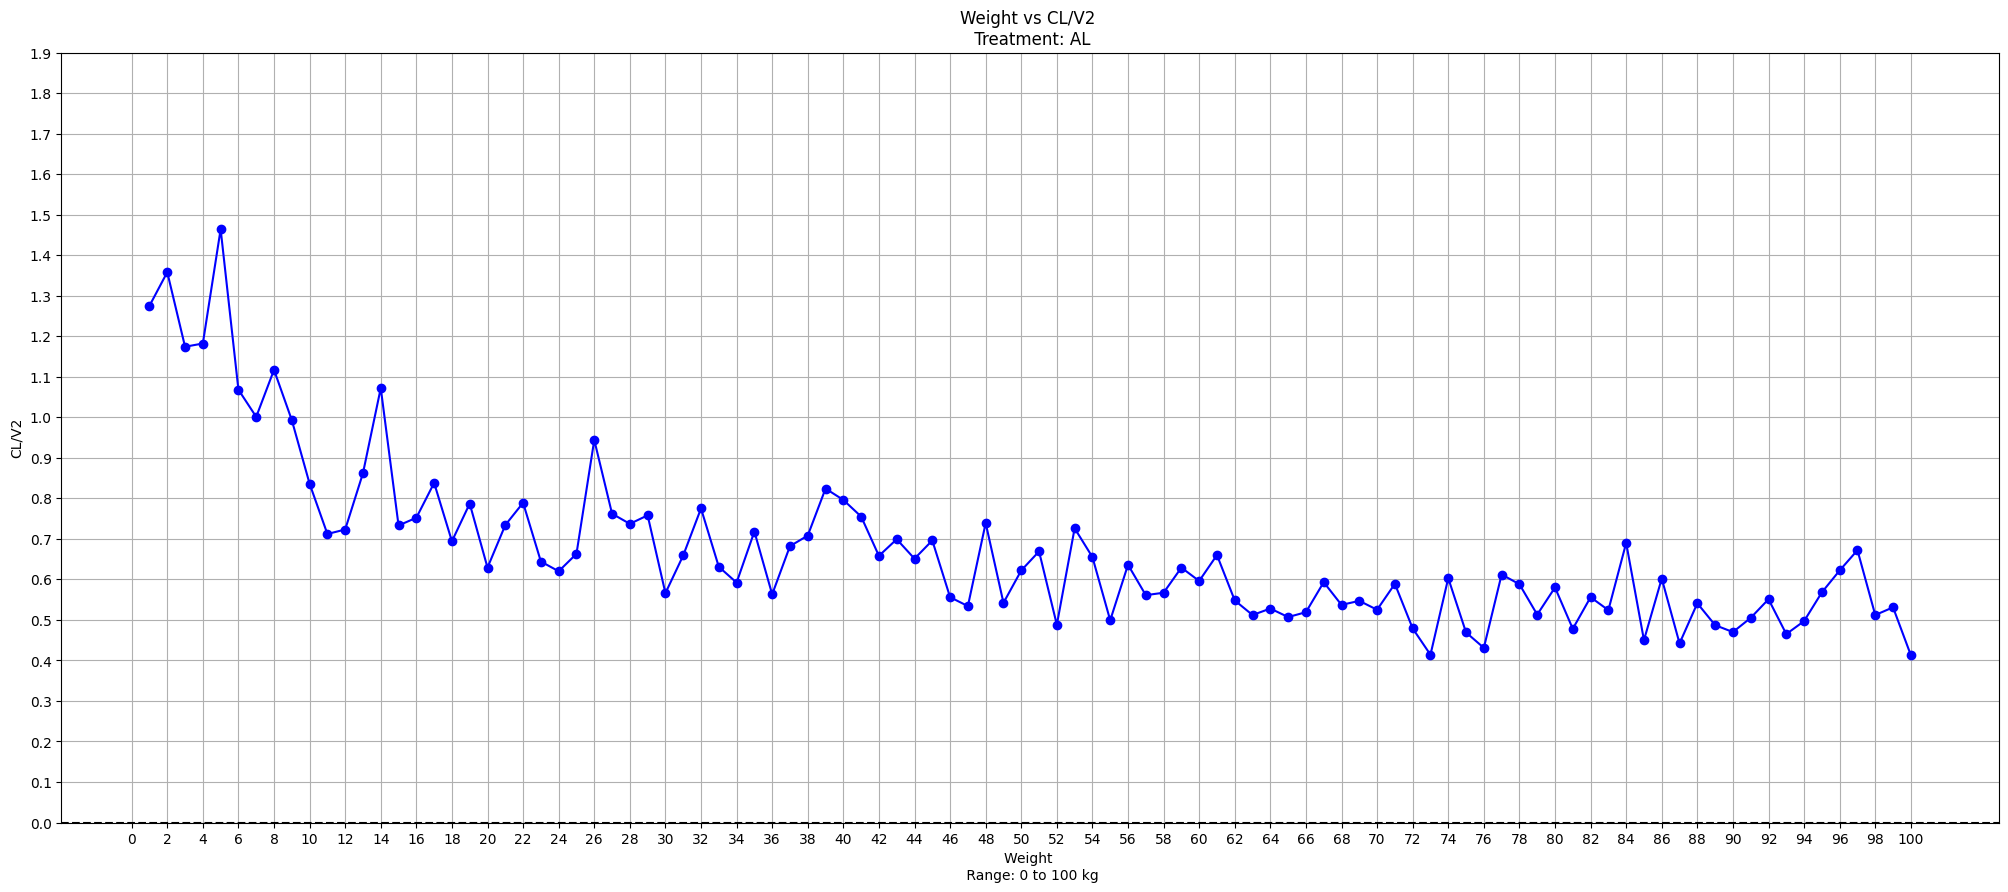

In [13]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(df_parameters_combined['WEIGHT'], df_parameters_combined['CL/V2'], marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 0 to 100 kg')
plt.ylabel('CL/V2')
plt.title('Weight vs CL/V2 \n Treatment: AL')
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 2, 0.1))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_parameter_analysis_01.png")  # Save the plot as a PNG file
plt.show()